## Loss 분석

[Log-Ratio Loss](https://openaccess.thecvf.com/content_CVPR_2019/papers/Kim_Deep_Metric_Learning_Beyond_Binary_Supervision_CVPR_2019_paper.pdf)을 활용하여 영상 $X$와 영상 $Y$ 간의 유사도가 벡터 $h_X$와 $h_Y$ 간의 유사도와 비슷하다록 학습합니다:

$$
\big\{\log{\frac{\mathrm{D}(X,Y)}{\mathrm{D}(X,Z)}} - \log{\frac{1-\mathrm{sim}(h_X,h_Y)}{1-\mathrm{sim}(h_X,h_Z)}}\big\}^2
$$

먼저, 학습함에 따라 loss가 어떻게 감소하는지 확인합니다:

In [ ]:
import os
import torch
import utils
import numpy as np
import matplotlib.pyplot as plt

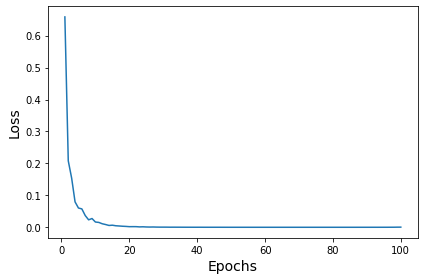

In [13]:
logs = []
with open('log.txt', 'r') as f:
    log = {}
    for line in f:
        term = line.split('\t')
        if len(term) < 2:
            logs.append(log)
            log = {}
        else:
            log[term[0]] = float(term[1])
            
epochs = [log['epoch'] for log in logs]
losses = [log['loss'] for log in logs]

plt.plot(epochs, losses)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.tight_layout()
plt.show()

## Correlation (연관도) 분석

실제 영상 유사도와 벡터간의 거리 간의 연관성을 확인합니다. 먼저 training set을 로드합니다:

In [2]:
video_size = 20
channels = ['ir01.png', 'ir02.png', 'swir.png', 'wv.png']

# Read validation set
video2image = {}
with open('video2image.txt', 'r') as f:
    for i, line in enumerate(f):
        video2image[i+1] = [int(x) for x in line.split(',')]
        
data_x, data_y, data_z, sim_xy, sim_xz = [], [], [], [], []
with open('train.txt', 'r') as f:
    for line in f:
        terms = line.split('\t')

        idx_x, idx_y, idx_z = int(terms[0]), int(terms[1]), int(terms[2])
        video_x, video_y, video_z = [], [], []
        for i in range(video_size):
            v_x = torch.stack([utils.read_image('images/image_{}/{}'.format(video2image[idx_x][i], channel)) for channel in channels], 0)
            v_y = torch.stack([utils.read_image('images/image_{}/{}'.format(video2image[idx_y][i], channel)) for channel in channels], 0)
            v_z = torch.stack([utils.read_image('images/image_{}/{}'.format(video2image[idx_z][i], channel)) for channel in channels], 0)
            video_x.append(v_x)
            video_y.append(v_y)
            video_z.append(v_z)
        video_x, video_y, video_z = torch.stack(video_x, 0), torch.stack(video_y, 0), torch.stack(video_z, 0)

        data_x.append(video_x)
        data_y.append(video_y)
        data_z.append(video_z)
        sim_xy.append(float(terms[3]))
        sim_xz.append(float(terms[4]))
    
data_x, data_y, data_z = torch.stack(data_x, 0), torch.stack(data_y, 0), torch.stack(data_z, 0)
sim_xy, sim_xz = torch.tensor(sim_xy), torch.tensor(sim_xz)
data_size, video_length, video_channels, video_height, video_width = data_x.shape

In [3]:
trained_model = torch.load(os.path.join('models', 'model_ep_100.pt'))
device = next(trained_model.parameters()).device

trained_model.eval()
data_x, data_y, data_z = torch.flatten(data_x, 3, 4), torch.flatten(data_y, 3, 4), torch.flatten(data_z, 3, 4)
emb_x, emb_y, emb_z = [], [], []

for i in range(data_size):
    _data_x, _data_y, _data_z = data_x[i:i+1], data_y[i:i+1], data_z[i:i+1]
    emb_x.append(trained_model.embed_video(_data_x.to(device)).detach().cpu())
    emb_y.append(trained_model.embed_video(_data_y.to(device)).detach().cpu())
    emb_z.append(trained_model.embed_video(_data_z.to(device)).detach().cpu())
    
emb_x = torch.cat(emb_x, 0)
emb_y = torch.cat(emb_y, 0)
emb_z = torch.cat(emb_z, 0)

연관도:	 -0.9753580952989188 



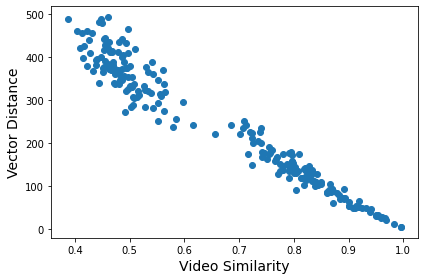

In [16]:
dist_xy = torch.norm(emb_x - emb_y, dim=1)
dist_xz = torch.norm(emb_x - emb_z, dim=1)
dist = dist_xy.tolist() + dist_xz.tolist()
sim = sim_xy.tolist() + sim_xz.tolist()

corr = np.corrcoef(sim, dist)[0,1]
print('연관도:\t', corr, '\n')

plt.scatter(sim, dist)
plt.xlabel('Video Similarity', fontsize=14)
plt.ylabel('Vector Distance', fontsize=14)
plt.tight_layout()
plt.show()

## Hyperparameter 튜닝

Validation (검증) set을 활용하여 최적의 epoch를 찾습니다. 먼저, validation을 로드합니다:

In [17]:
video_size = 20
channels = ['ir01.png', 'ir02.png', 'swir.png', 'wv.png']

# Read validation set
video2image = {}
with open('video2image.txt', 'r') as f:
    for i, line in enumerate(f):
        video2image[i+1] = [int(x) for x in line.split(',')]
        
data_x, data_y, data_z, sim_xy, sim_xz = [], [], [], [], []
with open('valid.txt', 'r') as f:
    for line in f:
        terms = line.split('\t')

        idx_x, idx_y, idx_z = int(terms[0]), int(terms[1]), int(terms[2])
        video_x, video_y, video_z = [], [], []
        for i in range(video_size):
            v_x = torch.stack([utils.read_image('images/image_{}/{}'.format(video2image[idx_x][i], channel)) for channel in channels], 0)
            v_y = torch.stack([utils.read_image('images/image_{}/{}'.format(video2image[idx_y][i], channel)) for channel in channels], 0)
            v_z = torch.stack([utils.read_image('images/image_{}/{}'.format(video2image[idx_z][i], channel)) for channel in channels], 0)
            video_x.append(v_x)
            video_y.append(v_y)
            video_z.append(v_z)
        video_x, video_y, video_z = torch.stack(video_x, 0), torch.stack(video_y, 0), torch.stack(video_z, 0)

        data_x.append(video_x)
        data_y.append(video_y)
        data_z.append(video_z)
        sim_xy.append(float(terms[3]))
        sim_xz.append(float(terms[4]))
    
data_x, data_y, data_z = torch.stack(data_x, 0), torch.stack(data_y, 0), torch.stack(data_z, 0)
sim_xy, sim_xz = torch.tensor(sim_xy), torch.tensor(sim_xz)
data_size, video_length, video_channels, video_height, video_width = data_x.shape

data_x, data_y, data_z = torch.flatten(data_x, 3, 4), torch.flatten(data_y, 3, 4), torch.flatten(data_z, 3, 4)

다음으로, 최적의 epoch를 찾습니다:

In [19]:
best_corr, best_epoch = 1e10, -1

for epoch in range(5, 101, 5):
    trained_model = torch.load(os.path.join('models', 'model_ep_{}.pt'.format(epoch)))
    device = next(trained_model.parameters()).device
    
    trained_model.eval()
    emb_x, emb_y, emb_z = [], [], []
    
    for i in range(data_size):
        _data_x, _data_y, _data_z = data_x[i:i+1], data_y[i:i+1], data_z[i:i+1]
        emb_x.append(trained_model.embed_video(_data_x.to(device)).detach().cpu())
        emb_y.append(trained_model.embed_video(_data_y.to(device)).detach().cpu())
        emb_z.append(trained_model.embed_video(_data_z.to(device)).detach().cpu())
    
    emb_x = torch.cat(emb_x, 0)
    emb_y = torch.cat(emb_y, 0)
    emb_z = torch.cat(emb_z, 0)
    
    dist_xy = torch.norm(emb_x - emb_y, dim=1)
    dist_xz = torch.norm(emb_x - emb_z, dim=1)
    dist = dist_xy.tolist() + dist_xz.tolist()
    sim = sim_xy.tolist() + sim_xz.tolist()

    corr = np.corrcoef(sim, dist)[0,1]
    if corr < best_corr:
        best_corr = corr
        best_epoch = epoch
    print('Epoch:\t\t', epoch)
    print('Correlation:\t', corr, '\n')

Epoch:	 5
Correlation:	 -0.9713542147489228 

Epoch:	 10
Correlation:	 -0.9711769790709727 

Epoch:	 15
Correlation:	 -0.9748615712059845 

Epoch:	 20
Correlation:	 -0.9749376645122731 

Epoch:	 25
Correlation:	 -0.975026530093132 

Epoch:	 30
Correlation:	 -0.9747437922921761 

Epoch:	 35
Correlation:	 -0.9747095962883977 

Epoch:	 40
Correlation:	 -0.9749971583333527 

Epoch:	 45
Correlation:	 -0.9749359719481867 

Epoch:	 50
Correlation:	 -0.9750042503470625 

Epoch:	 55
Correlation:	 -0.9750188335454547 

Epoch:	 60
Correlation:	 -0.9750754192199352 

Epoch:	 65
Correlation:	 -0.9751129222406035 

Epoch:	 70
Correlation:	 -0.9750185138450883 

Epoch:	 75
Correlation:	 -0.9750459995338068 

Epoch:	 80
Correlation:	 -0.9751322693900029 

Epoch:	 85
Correlation:	 -0.9750794736142353 

Epoch:	 90
Correlation:	 -0.9750826884405227 

Epoch:	 95
Correlation:	 -0.9750381097409784 

Epoch:	 100
Correlation:	 -0.9753580952989188 



최적의 epoch의 모델을 활용하여 test set을 활용하여 평가합니다. 먼저 test set을 로드합니다:

In [20]:
video_size = 20
channels = ['ir01.png', 'ir02.png', 'swir.png', 'wv.png']

# Read validation set
video2image = {}
with open('video2image.txt', 'r') as f:
    for i, line in enumerate(f):
        video2image[i+1] = [int(x) for x in line.split(',')]
        
data_x, data_y, data_z, sim_xy, sim_xz = [], [], [], [], []
with open('test.txt', 'r') as f:
    for line in f:
        terms = line.split('\t')

        idx_x, idx_y, idx_z = int(terms[0]), int(terms[1]), int(terms[2])
        video_x, video_y, video_z = [], [], []
        for i in range(video_size):
            v_x = torch.stack([utils.read_image('images/image_{}/{}'.format(video2image[idx_x][i], channel)) for channel in channels], 0)
            v_y = torch.stack([utils.read_image('images/image_{}/{}'.format(video2image[idx_y][i], channel)) for channel in channels], 0)
            v_z = torch.stack([utils.read_image('images/image_{}/{}'.format(video2image[idx_z][i], channel)) for channel in channels], 0)
            video_x.append(v_x)
            video_y.append(v_y)
            video_z.append(v_z)
        video_x, video_y, video_z = torch.stack(video_x, 0), torch.stack(video_y, 0), torch.stack(video_z, 0)

        data_x.append(video_x)
        data_y.append(video_y)
        data_z.append(video_z)
        sim_xy.append(float(terms[3]))
        sim_xz.append(float(terms[4]))
    
data_x, data_y, data_z = torch.stack(data_x, 0), torch.stack(data_y, 0), torch.stack(data_z, 0)
sim_xy, sim_xz = torch.tensor(sim_xy), torch.tensor(sim_xz)
data_size, video_length, video_channels, video_height, video_width = data_x.shape

data_x, data_y, data_z = torch.flatten(data_x, 3, 4), torch.flatten(data_y, 3, 4), torch.flatten(data_z, 3, 4)

In [21]:
trained_model = torch.load(os.path.join('models', 'model_ep_{}.pt'.format(best_epoch)))
device = next(trained_model.parameters()).device

trained_model.eval()
emb_x, emb_y, emb_z = [], [], []

for i in range(data_size):
    _data_x, _data_y, _data_z = data_x[i:i+1], data_y[i:i+1], data_z[i:i+1]
    emb_x.append(trained_model.embed_video(_data_x.to(device)).detach().cpu())
    emb_y.append(trained_model.embed_video(_data_y.to(device)).detach().cpu())
    emb_z.append(trained_model.embed_video(_data_z.to(device)).detach().cpu())
    
emb_x = torch.cat(emb_x, 0)
emb_y = torch.cat(emb_y, 0)
emb_z = torch.cat(emb_z, 0)

연관도:	 -0.9553013183938571 



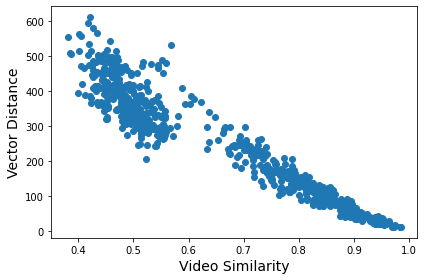

In [22]:
dist_xy = torch.norm(emb_x - emb_y, dim=1)
dist_xz = torch.norm(emb_x - emb_z, dim=1)
dist = dist_xy.tolist() + dist_xz.tolist()
sim = sim_xy.tolist() + sim_xz.tolist()

corr = np.corrcoef(sim, dist)[0,1]
print('연관도:\t', corr, '\n')

plt.scatter(sim, dist)
plt.xlabel('Video Similarity', fontsize=14)
plt.ylabel('Vector Distance', fontsize=14)
plt.tight_layout()
plt.show()